# walkthrough of an vine copula (vinecop) application on financial (US ETFs) dependence modeling and simulation.

- data preprocessing and exploratory data analysis
- make marginal cdf/ppf, transform from raw return to copula data
- fit 'rvine', draw, do full simulation
- fit 'cvine', draw, do cond simulation (given **SPY** scenario)


initialization, fetch data, preprocess


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yfinance as yf

import torchvinecopulib as tvc

lst_ticker = [
    "SPY",
    "QQQ",
    "DIA",
    "IJH",
    "VTI",
    "IWM",
    "XLF",
    "XLE",
    "XLK",
    "EFA",
    "EWA",
    "EWJ",
    "EEM",
    "FXI",
    "AGG",
    "TLT",
    "GLD",
    "SLV",
    "USO",
    "UNG",
]
print(lst_ticker)
raw_df = yf.download(lst_ticker, start="2010-01-01")
raw_df.index = pd.DatetimeIndex(raw_df.index)
raw_df = raw_df["Adj Close"].ffill()
# calc simple retn
NUM_DAY_INTVL = 1
df_retn_adjclose_simple_last_intvl = np.expm1(np.log(raw_df)[::NUM_DAY_INTVL].diff(1).dropna())
#
NUM_SIM = 50000
print(f"cuda (GPU) avail? {torch.cuda.is_available()}\n")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

['SPY', 'QQQ', 'DIA', 'IJH', 'VTI', 'IWM', 'XLF', 'XLE', 'XLK', 'EFA', 'EWA', 'EWJ', 'EEM', 'FXI', 'AGG', 'TLT', 'GLD', 'SLV', 'USO', 'UNG']


[*********************100%%**********************]  20 of 20 completed

cuda (GPU) avail? True



chart rolling bidep between each asset and SPY


In [46]:
f_bidep = tvc.util.kendall_tau
dct_dep_spy = {}
for df in df_retn_adjclose_simple_last_intvl.rolling(
    window=252 // NUM_DAY_INTVL, step=int(np.sqrt(252) // NUM_DAY_INTVL)
):
    if df.shape[0] >= 252 // NUM_DAY_INTVL:
        dct_dep_spy[df.index[-1]] = {
            k: f_bidep(torch.from_numpy(df[[k]].values), torch.from_numpy(df[["SPY"]].values))
            for k in df.keys()
        }

Text(0.5, 1.0, 'Rolling bivariate dependence (kendall_tau), between ETFs and SPY.')

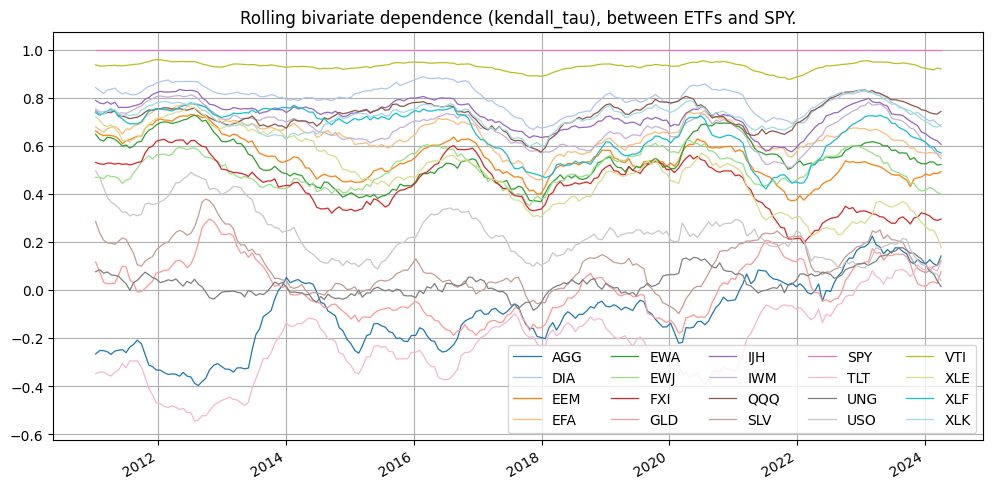

In [50]:
pd.DataFrame(dct_dep_spy).T.plot(figsize=(12, 6), style="-", alpha=1, lw=0.9, colormap="tab20")
plt.legend(ncol=5)
plt.grid()
plt.title(f"Rolling bivariate dependence ({f_bidep.__name__}), between ETFs and SPY.")

make marginal cdf_ppf functions; transform from raw data (-∞,∞)-> copula data (0,1)


In [51]:
from scipy import stats
from random import seed as r_seed
from scipy.special import ndtr
from scipy.interpolate import CubicSpline


def make_cdf_ppf(
    vec_obs: np.array,
    mtd_margin: str,
    seed: int,
    lst_distribution: list = [
        stats.t,
        stats.nct,
        stats.johnsonsu,
        stats.tukeylambda,
    ],
) -> pd.Series:
    """fit marginal univariate distributions, return fitted cdf/ppf functions
    # ! band_width for np fit from:
    Dhaker, H., Deme, E. H., & Ciss, Y. (2021).
    β-Divergence loss for the kernel density estimation with bias reduced.
    Statistical Theory and Related Fields, 5(3), 221-231.
    """
    r_seed(seed)
    np.random.seed(seed=seed)
    vec_clean = np.sort(vec_obs[np.isfinite(vec_obs)])
    if mtd_margin == "np":
        # The constant has beta = 1.7320508075688772 from
        # (4 * beta**4 / (9 * beta**4 - 36 * beta**3 + 90 * beta**2 + 270 * beta + 105) * sqrt(2 / pi))**(1 / 9)
        band_width = vec_clean.std() * 0.6973425390765554 * (len(vec_clean)) ** (-1 / 9)

        # empirical cdf, semi parametric approach, from mixture
        @np.vectorize
        def res_cdf(quantile: np.array):
            # ±∞ return to (0,1) cdf
            return ndtr((quantile - vec_clean) / band_width).mean()

        vec_F, idx = np.unique(res_cdf(vec_clean), return_index=True)
        func_spline = CubicSpline(x=vec_F, y=vec_clean[idx])

        def res_ppf(percentage: np.array):
            # (0,1) cdf to ±∞ return
            return func_spline(percentage)

    elif mtd_margin == "p":
        dist, par, bic2, lnn2 = None, None, np.inf, np.log(len(vec_clean)) / 2
        for iter_dist in lst_distribution:
            iter_par = iter_dist.fit(vec_clean)
            iter_bic2 = len(iter_par) * lnn2 - iter_dist.logpdf(vec_clean, *iter_par).sum()
            if iter_bic2 < bic2:
                dist, par, bic2 = iter_dist, iter_par, iter_bic2
        res_cdf, res_ppf = lambda vec: dist.cdf(vec, *par), lambda vec: dist.ppf(vec, *par)

    return pd.Series({"cdf": res_cdf, "ppf": res_ppf})

In [52]:
arr_cdf_ppf = np.apply_along_axis(
    func1d=lambda vec: make_cdf_ppf(vec_obs=vec, mtd_margin="np", seed=0),
    axis=0,
    arr=df_retn_adjclose_simple_last_intvl.values,
)

In [53]:
V_mvcp = torch.as_tensor(
    np.hstack(
        [
            cdf(df_retn_adjclose_simple_last_intvl.values[:, [idx]])
            for idx, cdf in enumerate(arr_cdf_ppf[0])
        ]
    ),
    device=DEVICE,
)
print(V_mvcp.min(), V_mvcp.max())

tensor(0.0001, device='cuda:0', dtype=torch.float64) tensor(0.9999, device='cuda:0', dtype=torch.float64)


make vinecop from multivariate copula observations

**Rvine, full sim**


In [54]:
# read lst_sim from right to left
mdl_vcp = tvc.vinecop.vcp_from_obs(V_mvcp)

print(mdl_vcp)

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 20,
 'num_obs': 3_588,
 'num_par': 171,
 'negloglik': -56382.1792,
 'aic': -112422.3585,
 'bic': -111364.6636,
 'matrix': '[[ 7 14  0 13 15  9 19 10 18  1 17  5  8  6 12 16  2  3  4 11]'
           ' [-1  6 14  0 13 15  9 19 10 18  1 17  5  8 12 16 11  4  3  2]'
           ' [-1 -1 11 14  0 13 15  9 19 10 18  1 17  5  8 12 16  2  3  4]'
           ' [-1 -1 -1  5 14  0 13 15  9 19 10 18  1 17  8 12 16  2  4  3]'
           ' [-1 -1 -1 -1  4 14  0 13 15  9 19 10 18  1 17  8 12 16  2  3]'
           ' [-1 -1 -1 -1 -1 14 15  2  3  9 17  8 16 19 10 12  1  0 18 13]'
           ' [-1 -1 -1 -1 -1 -1  0 15  2  3  9 17  8 16 19 10 12  1 18 13]'
           ' [-1 -1 -1 -1 -1 -1 -1 13 15  2  3  9 17  8 16 19 10 12  1 18]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1  9 15  2  3 19 10 18 17  1 12 16  8]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1  2 15 19 10 18  1 17  8 12 16  3]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 15 19 10 18  1  3 12 16  8 17]'
          

In [55]:
for _ in enumerate(df_retn_adjclose_simple_last_intvl.columns):
    print(_)

(0, 'AGG')
(1, 'DIA')
(2, 'EEM')
(3, 'EFA')
(4, 'EWA')
(5, 'EWJ')
(6, 'FXI')
(7, 'GLD')
(8, 'IJH')
(9, 'IWM')
(10, 'QQQ')
(11, 'SLV')
(12, 'SPY')
(13, 'TLT')
(14, 'UNG')
(15, 'USO')
(16, 'VTI')
(17, 'XLE')
(18, 'XLF')
(19, 'XLK')


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Level 0, BiDep Metric chatterjee_xi'}>,
 <networkx.classes.graph.Graph at 0x1171a711590>)

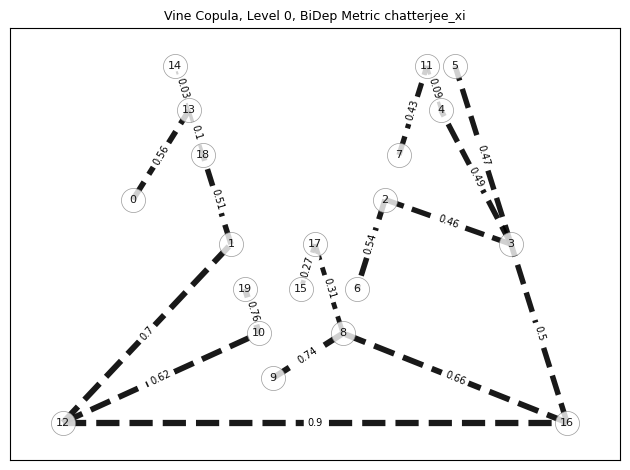

In [56]:
# SPY is vertex 12
mdl_vcp.draw_lv()

full sim


In [58]:
print(mdl_vcp.lst_sim)
V_sim = mdl_vcp.sim(num_sim=NUM_SIM, device=DEVICE)
print(V_sim)

[7, 6, 11, 5, 4, 14, 0, 13, 9, 2, 15, 3, 17, 8, 16, 18, 1, 12, 10, 19]
tensor([[0.2807, 0.7801, 0.9882,  ..., 0.8513, 0.9275, 0.8805],
        [0.9829, 0.8063, 0.8233,  ..., 0.7870, 0.2991, 0.6501],
        [0.2669, 0.3706, 0.6751,  ..., 0.7772, 0.5792, 0.4968],
        ...,
        [0.6231, 0.8924, 0.6647,  ..., 0.2471, 0.9578, 0.9722],
        [0.6654, 0.5580, 0.8376,  ..., 0.4060, 0.3185, 0.6877],
        [0.7621, 0.0141, 0.0324,  ..., 0.0086, 0.0094, 0.0201]],
       device='cuda:0', dtype=torch.float64)


In [59]:
arr_sim = np.hstack([ppf(V_sim[:, [idx]].cpu()) for idx, ppf in enumerate(arr_cdf_ppf[1])])

print(arr_sim.min(), arr_sim.max())
print(
    "\nkendall tau wrt SPY, of simulations",
    pd.DataFrame(arr_sim, columns=df_retn_adjclose_simple_last_intvl.columns).corr(
        method="kendall"
    )["SPY"],
)
print(
    "\nkendall tau wrt SPY, of raw obs",
    df_retn_adjclose_simple_last_intvl.corr(method="kendall")["SPY"],
)

-0.2560322484022775 0.3053505763990141

kendall tau wrt SPY, of simulations Ticker
AGG   -0.088934
DIA    0.796458
EEM    0.556034
EFA    0.645888
EWA    0.567485
EWJ    0.500561
FXI    0.431058
GLD    0.041425
IJH    0.727880
IWM    0.676127
QQQ    0.734886
SLV    0.138943
SPY    1.000000
TLT   -0.214518
UNG    0.036926
USO    0.263826
VTI    0.932280
XLE    0.484681
XLF    0.656339
XLK    0.722482
Name: SPY, dtype: float64

kendall tau wrt SPY, of raw obs Ticker
AGG   -0.084251
DIA    0.795463
EEM    0.548774
EFA    0.645269
EWA    0.549332
EWJ    0.500141
FXI    0.430091
GLD    0.023184
IJH    0.725134
IWM    0.674604
QQQ    0.735168
SLV    0.129238
SPY    1.000000
TLT   -0.209706
UNG    0.037742
USO    0.234418
VTI    0.931927
XLE    0.468002
XLF    0.647783
XLK    0.724629
Name: SPY, dtype: float64


make vinecop from multivariate copula observations

**Cvine, cond sim**


In [60]:
# user specify the priority vertices list, used in fitting and also in the conditional simulation
mdl_vcp_cond = tvc.vinecop.vcp_from_obs(
    V_mvcp,
    cdrvine="cvine",
    lst_first=[12],
)

print(mdl_vcp_cond)

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 20,
 'num_obs': 3_588,
 'num_par': 166,
 'negloglik': -55927.332,
 'aic': -111522.664,
 'bic': -110495.8959,
 'matrix': '[[ 4 14 18 13 19 15  7  6  5 16  1  9 17  3 11  0  2 10  8 12]'
           ' [-1 14 18 13 19 15  7  6  5 16  1  9 17  3 11  0  2 10  8 12]'
           ' [-1 -1 13 18 19 15  7  6  5 16  1  9 17  3 11  0  2 10  8 12]'
           ' [-1 -1 -1 18 19 15  7  6  5 16  1  9 17  3 11  0  2 10  8 12]'
           ' [-1 -1 -1 -1 15 19  7  6  5 16  1  9 17  3 11  0  2 10  8 12]'
           ' [-1 -1 -1 -1 -1  7 19  6  5 16  1  9 17  3 11  0  2 10  8 12]'
           ' [-1 -1 -1 -1 -1 -1  6 19  5 16  1  9 17  3 11  0  2 10  8 12]'
           ' [-1 -1 -1 -1 -1 -1 -1  5 19 16  1  9 17  3 11  0  2 10  8 12]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 16 19  1  9 17  3 11  0  2 10  8 12]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1  1 19  9 17  3 11  0  2 10  8 12]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  9 19 17  3 11  0  2 10  8 12]'
           '

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Level 0, BiDep Metric chatterjee_xi'}>,
 <networkx.classes.graph.Graph at 0x1171b54c610>)

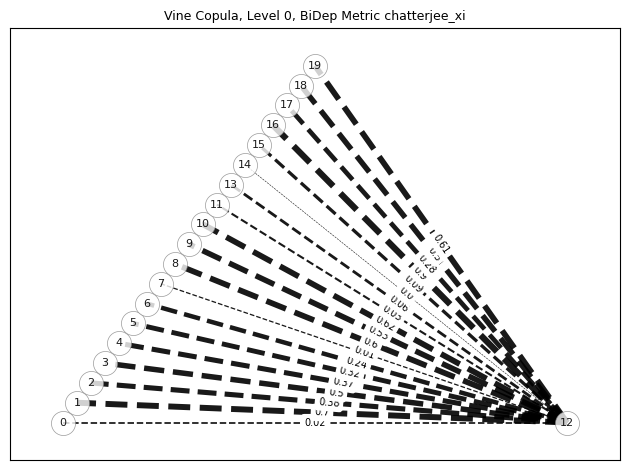

In [61]:
# SPY is vertex 12
mdl_vcp_cond.draw_lv()

In [66]:
# cond sim: user specified values for first set (vertex 12),
# a tail scenario with CDF(SPY)=.05
dct_first_vs = {(12, frozenset()): torch.ones(size=(NUM_SIM, 1), device=DEVICE) * (0.05)}
V_sim_cond = mdl_vcp.sim(num_sim=NUM_SIM, dct_first_vs=dct_first_vs, device=DEVICE)
arr_sim_cond = np.hstack(
    [ppf(V_sim_cond[:, [idx]].cpu()) for idx, ppf in enumerate(arr_cdf_ppf[1])]
)
print("specified value of SPY:", arr_sim_cond[:, 12])
print(arr_sim_cond[:3, :])

specified value of SPY: [-0.01724962 -0.01724962 -0.01724962 ... -0.01724962 -0.01724962
 -0.01724962]
[[-0.03271749 -0.02781722 -0.01591934 -0.05263972 -0.03592448 -0.03269948
  -0.01634737 -0.05071683 -0.01748391 -0.01070479  0.02072877 -0.03956835
  -0.01724962 -0.02581112  0.036061    0.17406216 -0.01347682 -0.04143302
  -0.11806249  0.01409717]
 [-0.0011284  -0.01721919  0.0009337  -0.01885438 -0.00415373 -0.01368162
   0.00490506  0.03733707 -0.02601296 -0.0190035  -0.00638987  0.04074405
  -0.01724962 -0.00988239  0.03151546  0.01065521 -0.01673955  0.00816289
  -0.02292581 -0.00776198]
 [ 0.0012125  -0.01909313 -0.0080625  -0.03205944 -0.02811026 -0.01638545
  -0.01872254 -0.00327557 -0.02594838 -0.01713671 -0.00222465 -0.013844
  -0.01724962  0.00807526  0.00103176 -0.00642912 -0.01828964 -0.02280884
  -0.03229387 -0.00043717]]
